##0 Setup

In [ ]:
!pip install latextable

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for latextable: filename=latextable-0.3.0-py3-none-any.whl size=7254 sha256=a5b467ceffe070ef37352ad63cd133cc556df0d9136842625f57d95d9d504436
  Stored in directory: /root/.cache/pip/wheels/a3/8d/a3/41e5c8fb7490c6e93ceb64ca1740f172b7ea837fe42ac41ce0
Successfully built latextable


In [ ]:
import random
from random import randint, choice, sample

import latextable
from texttable import Texttable

import sympy
from sympy import latex,simplify,nsimplify,sympify,Symbol,symbols
from sympy import Rational,Integer,Float,S,oo
from sympy import log,Pow,powsimp,powdenest,sqrt,real_root,lcm
from sympy import ImageSet,Interval,Lambda,Contains,Union,Piecewise

variables = 'a b c d m n p q r s t w x y'
variables = symbols(variables, real=True)
variables += (Symbol('z'),)
a,b,c,d,m,n,p,q,r,s,t,w,x,y,z = variables

In [ ]:
class LinFunc():
    """
    Represent a linear function.

    Attributes
    ----------
        slope : number (int, float, or Rational)
        intercept : number
        variable : sympy symbol, default=x
        label : str, default='f'
        expr : sympy expression
        domain : sympy set, default=S.Reals
        precision : int or 'auto', default='auto'
    """

    def __init__(self, slope, pt, variable=x, label='f', domain=S.Reals, precision=2):
        """
        Construct linear function object from slope and y-intercept.

        Parameters
        ----------
            slope : number (int, float, or Rational)
            pt : number or list
            variable : sympy symbol, default=x
            label : str, default='f'
            domain : sympy set, default=S.Reals
            precision : int or 'auto', default='auto'
        """
        
        self.slope, pt = sympify([slope, pt])
        
        self.intercept = pt[1] - pt[0]*self.slope if type(pt)==list else pt
        self.expr = self.slope*variable + self.intercept

        self.variable = variable
        self.label = label
        self.domain = domain
        self.precision = precision
    
    def __str__(self):
        """Return LaTeX formatted slope-intercept form."""
        
        if self.slope in [0,1]:
            slopeInt = ''
        elif self.slope == -1:
            slopeInt = '-'
        else:
            slopeInt = latexify(self.slope, self.precision)
        slopeInt += latex(self.variable) if self.slope!=0 else '' 
        
        intercept = latexify(self.intercept, self.precision)
        if self.intercept>0 and self.slope!=0:
            slopeInt += ' + '
        if self.intercept!=0 or self.slope==0:
            slopeInt += intercept
            
        return slopeInt
    
    @classmethod
    def fromPts(cls, pt1, pt2, variable=x, label='f', domain=S.Reals, precision='auto'):
        """
        Construct linear function object from two ordered pairs.

        Parameters
        ----------
            pt1, pt2 : list or tuple
            variable : sympy symbol, default=x
            label : str, default='f'
        """

        pt1, pt2 = sympify([pt1, pt2])
        
        slope = (pt2[1] - pt1[1])/(pt2[0] - pt1[0])
        
        if pt1[0]==0:
            return cls(slope, pt1[1], variable, label, domain, precision)
        elif pt2[0]==0:
            return cls(slope, pt2[1], variable, label, domain, precision)
        else:
            return cls(slope, pt1, variable, label, domain, precision)

    def subs(self, input):
        """Return evaluation of function at input."""

        return self.expr.subs(self.variable, sympify(input))

    def subSet(self, preimage):
        """Return image of set."""

        return ImageSet(Lambda(self.variable, self.expr), preimage).intersect(S.Reals)

    def getRange(self):
        """Return range of function."""

        return self.subSet(self.domain)
        
    def solve(self, output):
        if self.slope == 0:
            return self.domain if output==self.intercept else None
        else:
            return (sympify(output)-self.intercept)/self.slope

    def getSlopeInt(self, notation='func'):
        """Return LaTeX formatted slope-intercept form."""

        if notation == 'func':
            return f'{self.label}({self.variable}) = ' + str(self)
        else:
            return notation + '=' + str(self)

    def getPtSlope(self, pt=1, notation='func'):
        """
        Return LaTeX formatted point-slope form.
        
        Parameter
        ---------
            pt : number or list/tuple
                Independent variable value or ordered pair.
        """

        pt = sympify(pt)
        if type(pt)!=list:
            pt = [pt] + [self.subs(pt)]
        
        ptTex = latexify(pt, self.precision)
        
        if self.slope in [0,1]:
            ptSlope = ''
        elif self.slope == -1:
            ptSlope = '-'
        else:
            ptSlope = latexify(self.slope, self.precision)
            
        if self.slope!=0:
            ptSlope += r'\left(' + latex(self.variable)
            ptSlope += '+' + ptTex[0][1:] if pt[0]<0 else '-' + ptTex[0]
            ptSlope += r'\right)'
        
        if pt[1]>0 and self.slope!=0:
            ptSlope += ' + '
        if pt[1]!=0 or self.slope==0:
            ptSlope += ptTex[1]
        
        if notation == 'func':
            return fr'{self.label}({self.variable}) = ' + ptSlope
        else:
            return notation + '=' + ptSlope
            
    def getStdForm(self, notation='y', mult=1):
        if self.slope == 0:
            mult = nsimplify(self.intercept).q
        elif self.intercept == 0:
            mult = nsimplify(self.slope).q
        else:
            mult *= abs(lcm(nsimplify(self.slope).q, nsimplify(self.intercept).q))
        mult = -mult if self.slope<=0 else mult
        
        stdForm = latex(nsimplify(mult*self.slope*self.variable - mult)) + notation
        stdForm += '=' + latex(nsimplify(-mult*self.intercept))
        
        return stdForm
        
    def getTable(self, nums, vals=True, vertical=True, labels=None):
        """
        Return LaTeX formatted table at given positions with or without blanks.
        
        Parameters
        ----------
            nums : list of ints
            vals : bool or list of bools or nonempty/empty strings ('')
        """
        
        vals = len(nums)*[vals] if type(vals)==bool else vals
        images = [signify(latexify(self.subs(jj), self.precision)) for jj in nums]
        images = [jj if vals[count] else r'\phantom{' + jj + r'}' for count,jj in enumerate(images)]
        
        if labels == None:
            labels = [signify(str(self.variable)), fr'${self.label}({self.variable})$']
        if vertical:
            header = labels
            rows = list(zip(nums,images))
        else:
            header = [labels[0]] + list(nums)
            rows = [[labels[1]] + images]
        
        return tableGenerator(header, rows)

class ExpFunc():
    """
    Represent an (unshifted) exponential function.

    Attributes
    ----------
        base : number (int, float, or Rational)
        intercept : number
        variable : sympy symbol, default=x
        label : str, default='f'
        expr : sympy expression
        domain : sympy set, default=S.Reals
        precision : int or 'auto', default='auto'
    """

    def __init__(self, base, pt, variable=x, label='f', domain=S.Reals, precision=2):
        """
        Construct exponential function object from base and y-intercept.

        Parameters
        ----------
            base : number (int, float, or Rational)
            intercept : number
            variable : sympy symbol, default=x
            label : str, default='f'
            domain : sympy set, default=S.Reals
            precision : int or 'auto', default='auto'
        """

        self.base, pt = sympify([base, pt])
        
        self.intercept = pt[1]/Pow(self.base,pt[0]) if type(pt)==list else pt
        self.expr = self.intercept*(self.base**variable)
        
        self.variable = variable
        self.label = label
        self.domain = domain
        self.precision = precision
    
    def __str__(self):
        """Return LaTeX formatted base-intercept form."""

        if self.intercept == 1:
            baseInt = ''
        elif self.intercept == -1:
            baseInt = '-'
        else:
            baseInt = latexify(self.intercept, self.precision)
            if type(self.base)==Integer and self.base>0:
                baseInt += r' \cdot '
            
        if type(self.base)==Float or abs(self.base.q)>999:
            base = latexify(self.base, self.precision)
            baseInt += fr'({base})^{self.variable}'
        else:            
            baseInt += latex(self.base**self.variable)
            
        return baseInt
    
    @classmethod
    def fromPts(cls, pt1, pt2, variable=x, label='f', domain=S.Reals, precision='auto'):
        """
        Construct exponential function object from two ordered pairs.

        Parameters
        ----------
            pt1, pt2 : list or tuple
            variable : sympy symbol, default=x
            label : str, default='f'
        """
        
        pt1, pt2 = sympify([pt1, pt2])
        
        base = Pow(pt2[1]/pt1[1], 1/(pt2[0]-pt1[0]))
        
        if pt1[0]==0:
            return cls(base, pt1[1], variable, label, domain, precision)
        elif pt2[0]==0:
            return cls(base, pt2[1], variable, label, domain, precision)
        else:
            return cls(base, pt1, variable, label, domain, precision)

    def subs(self, input):
        """Return evaluation of function at input."""

        return self.expr.subs(self.variable, sympify(input))

    def subSet(self, preimage):
        """Return image of set."""

        return ImageSet(Lambda(self.variable, self.expr), preimage).intersect(S.Reals)

    def getRange(self):
        """Return range of function."""

        return self.subSet(self.domain)
        
    def solve(self, output):
        """Return preimage of given output."""
        
        return log(sympify(output)/self.intercept, self.base)
    
    def getBaseInt(self, notation='func'):
        """Return LaTeX formatted base-intercept form."""

        if notation == 'func':
            return fr'{self.label}({self.variable}) = ' + str(self)
        else:
            return notation + '=' + str(self)

    def getPtBase(self, pt=1, notation='func'):
        """
        Return LaTeX formatted point-base form.
        
        Parameter
        ---------
            pt : number or list/tuple
                Independent variable value or ordered pair.
        """

        pt = sympify(pt)
        if type(pt)!=list:
            pt = [pt] + [self.subs(pt)]
         
        if pt[1] == 1:
            ptBase = ''
        elif pt[1] == -1:
            ptBase = '-'
        else:
            ptBase = latexify(pt[1], self.precision)
            if type(self.base)==Integer and self.base>0:
                ptBase += r' \cdot '
            
        if type(self.base)==Float or abs(self.base.q)>999:
            base = latexify(self.base, self.precision)
            ptBase += fr'({base})^' + r'{' + latex(self.variable-pt[0]) + r'}'
        else:
            ptBase += latex(self.base**(self.variable - pt[0]))
            
        if notation == 'func':
            return fr'{self.label}({self.variable}) = ' + ptBase
        else:
            return notation + '=' + ptBase
        
    def getTable(self, nums, vals=True, vertical=True, labels=None):
        """
        Return LaTeX formatted table at given positions with or without blanks.
        
        Parameters
        ----------
            nums : list of ints
            vals : bool or list of bools or nonempty/empty strings ('')
        """
        
        vals = len(nums)*[vals] if type(vals)==bool else vals
        images = [signify(latexify(self.subs(jj), self.precision)) for jj in nums]
        images = [jj if vals[count] else r'\phantom{' + jj + r'}' for count,jj in enumerate(images)]
        
        if labels == None:
            labels = [signify(str(self.variable)), fr'${self.label}({self.variable})$']
        if vertical:
            header = labels
            rows = list(zip(nums,images))
        else:
            header = [labels[0]] + list(nums)
            rows = [[labels[1]] + images]
        
        return tableGenerator(header, rows)


In [ ]:
class ArithSeq(LinFunc):
    """
    Represent an arithmetic sequence.

    Attributes
    ----------
        common : number (int, float, or Rational)
            Common difference.
        start : number
            First term (a_1 or f(1)).
        label : str, default='f'
        func : LinFunc
        terms : dict
    """

    def __init__(self, common, pt, variable=n, label='f', domain=S.Integers, precision=2):
        """
        Construct arithmetic sequence object from common difference and first term.

        Parameters
        ----------
            common : number (int, float, or Rational)
                Common difference.
            pt : number or list
                First term (a_1 or f(1)).
            label : str, default='f'
        """
        
        super().__init__(common, pt, variable, label, domain, precision)
        
        self.common = self.slope
        self.start = self.subs(1)
        self.terms = {0: self.intercept, 1: self.start, 2: self.subs(2), 3: self.subs(3)}
    
    def findTerm(self, num: int):
        """Return term at given index."""

        if num in self.terms.keys():
            return self.terms[num]
        else:
            return self.subs(num)
    
    def findTermNum(self, end):
        """Return index of given term."""

        if end in self.terms.values():
            return list(self.terms.keys())[list(self.terms.values()).index(end)]
        else:
            return self.solve(end)
    
    def getTerms(self, num: int, startnum=0):
        """Return dict of terms."""

        minNum = min(self.terms.keys())
        maxNum = max(self.terms.keys())
        if num > maxNum:
            for jj in range(maxNum+1, num+1):
                self.terms[jj] = self.terms[jj-1] + self.common
        if startnum < minNum:
            for jj in range(minNum-1, startnum-1, -1):
                self.terms[jj] = self.terms[jj+1] - self.common
        return self.terms
    
    def getExplicit(self, term=1):
        """
        Return LaTeX formatted explicit representation.
        
        Parameter
        ---------
            term : number or list/tuple
                Index of term or ordered pair.
        """

        return self.getSlopeInt() if term==0 else self.getPtSlope(term)
    
    def getRecursive(self, startnum=1):
        """
        Return LaTeX formatted recursive representation.

        Parameter
        ---------
            startnum : int
        """

        term = self.findTerm(startnum) if startnum!=1 else self.start
        recursive = fr'{self.label}(n) = {self.label}(n-1)'
        if self.common >= 0:
            recursive += ' + ' + latexify(self.common, self.precision)
        else:
            recursive += latexify(self.common, self.precision)
        recursive += fr',\quad {self.label}({startnum}) = {latexify(term, self.precision)}'
        return recursive
        
    def getSeqStr(self, nums=[1,2,3]):
        """
        Return LaTeX formatted list at given positions with or without blanks.
        
        Parameter
        ---------
            nums : list of ints or empty strings ('')
        """
        
        blank = r'\underline{\hspace{4mm}}'
        result = [latexify(self.findTerm(jj), self.precision) if type(jj)==int else blank for jj in nums]
        
        return (', ').join(result) + r', \ldots'

class GeoSeq(ExpFunc):
    """
    Represent a geometric sequence.

    Attributes
    ----------
        common : number (int, float, or Rational)
            Common ratio.
        start : number
            First term (a_1 or f(1)).
        label : str, default='f'
        func : ExpFunc
        terms : dict
    """

    def __init__(self, common, pt, variable=n, label='f', domain=S.Integers, precision=2):
        """
        Construct geometric sequence object from common ratio and first term.

        Parameters
        ----------
            common : number (int, float, or Rational)
                Common ratio.
            start : number
                First term (a_1 or f(1)).
            label : str, default='f'
        """
        
        super().__init__(common, pt, variable, label, domain, precision)

        self.common = self.base
        self.start = self.subs(1)
        self.terms = {0: self.intercept, 1: self.start, 2: self.subs(2), 3: self.subs(3)}
    
    def findTerm(self, num: int):
        """Return term at given index."""

        if num in self.terms.keys():
            return self.terms[num]
        else:
            return self.subs(num)
    
    def findTermNum(self, end):
        """Return index of given term."""

        if end in self.terms.values():
            return list(self.terms.keys())[list(self.terms.values()).index(end)]
        else:
            return self.solve(end)
    
    def getTerms(self, num: int, startnum=0):
        """Return list of terms."""

        minNum = int(min(self.terms.keys()))
        maxNum = int(max(self.terms.keys()))
        if num > maxNum:
            for jj in range(maxNum+1, num+1):
                self.terms[jj] = self.terms[jj-1]*self.common
        if startnum < minNum:
            for jj in range(minNum-1, startnum-1, -1):
                self.terms[jj] = Rational(self.terms[jj+1],self.common)
        return self.terms
    
    def getExplicit(self, term=1):
        """
        Return LaTeX formatted explicit representation.
        
        Parameter
        ---------
            term : number or list/tuple
                Index of term or ordered pair.
        """

        return self.getBaseInt() if term==0 else self.getPtBase(term)
    
    def getRecursive(self, startnum=1):
        """
        Return LaTeX formatted recursive representation.

        Parameter
        ---------
            startnum : int
        """

        term = self.findTerm(startnum) if startnum!=1 else self.start
        recursive = fr'{self.label}(n) = {latexify(self.common, self.precision)}\cdot {self.label}(n-1)'
        recursive += fr',\quad {self.label}({startnum}) = {latexify(term, self.precision)}'
        return recursive
        
    def getSeqStr(self, nums=[1,2,3]):
        """
        Return LaTeX formatted list at given positions with or without blanks.
        
        Parameter
        ---------
            nums : list of ints or empty strings ('')
        """
        
        blank = r'\underline{\hspace{4mm}}'
        result = [latexify(self.findTerm(jj), self.precision) if type(jj)==int else blank for jj in nums]
        
        return (', ').join(result) + r', \ldots'


In [ ]:
def chooseFloat(package):
  floatA = random.choice(package)
  return floatA

def getFloat(min=-10,max=10,roundby=2):
  return round(random.uniform(min, max), roundby)

def getInt(min= -4, max = 4, exclude=[0]):
  intA = random.choice([x for x in range(min,max+1) if x not in exclude])
  return sympify(intA)

def getVar(exclude=None):
  return random.choice([vrbl for vrbl in variables if vrbl not in exclude])

def getFrac(denommin= -4, denommax= 4, numermin = 1, numbermax = 4 , exclude = 0):# exclude 1 in denom later
  top = random.choice([x for x in range(numermin,numbermax+1) if x != exclude])
  bot = random.choice([x for x in range(denommin,denommax+1) if x != exclude])
  return latex(simplify(Rational(top,bot),evaluate=False))

def tableGenerator(header, rows, cols_align=None, cols_valign=None, expr='latex', table_env=False):
    """
    Generate a table.

    Parameters
    ----------
        header : list or tuple
        rows : 2-dimensional array
        cols_align : list or tuple, default=None
            List of column alignments ('l','c', or 'r'); if ``None``, all set to 'c'.
        expr : str, default='latex'
            LaTeX formatted.
        table_env : boolean, default=True
            Enclose in floating table environment (\begin{table}...).

    Returns
    -------
        str
    """

    table = Texttable()
    if cols_align == None:
        cols_align = len(header)*['c']
    if cols_valign == None:
        cols_valign = len(header)*['m']
    table.set_cols_align(cols_align)
    table.set_cols_valign(cols_valign)
    table.add_rows([header] + rows)

    if expr == 'latex':
        table = latextable.draw_latex(table)
        if not table_env:
            table = table.replace('\\begin{table}\n','').replace('\n\\end{table}','')
        return table
    else:
        return table.draw()
 
def signify(data):
    if type(data)==list:
        return [signify(jj) for jj in data]
    else:
        return '$' + str(data) + '$'
    
def latexify(data, precision=2):
    if type(data)==list:
        return [latexify(num, precision) for num in data]
    elif type(data)==dict:
        return {k:latexify(v, precision) for k,v in data.items()}
    elif type(data)==Float or abs(data.q)>999:
        return str(round(data,precision))
    else:
        return latex(data)

def brackify(data):
    return r'{' + str(data) + r'}'
        
def minipagify(left, right, vspace='0.25in'):
    string = '\\begin{minipage}[t]{0.5\\textwidth}\n'
    string += left + '\n\\end{minipage}\n'
    string += '\\begin{minipage}[t]{0.5\\textwidth}\n'
    string += right + '\n\\end{minipage}\n'
    string += f'\\vspace{brackify(vspace)}\n'
    return string

##ags.2.1.1 - Ratio ( don't work on this yet )


### instruction : Set up the equation and find the designated ratio.

#### section1

- Apples are on sale at the market at $4 pounds$ for $\$2.00$. What is the price for $1 pounds$.

  - problem:
  - equation : $ $
  - ratio : $ $
  - answer 
  - equation : $ 4 x = 200$
  - ratio : $\$0.50$

- Apples are on sale at the market at $4 pounds$ for $\$2.00$. Three apples weigh about a pound. About how much would $ 1 apple$ cost? (Round to the nearest cent.)

  - problem:
  - equation : $ $
  - ratio : $ $
  - answer 
  - equation : $ 3 x = 100$
  - ratio : $\$0.50$

- One dozen eggs cost $\$1.98$. How much does  cost? (Round to the nearest cent.)

  - problem:
  - equation : $ $
  - ratio : $ $
  - answer 
  - equation : $ 3 x = 100$
  - ratio : $\$0.50$








## ags.mod2.2.1 -  Find The Slope In Each Representation.

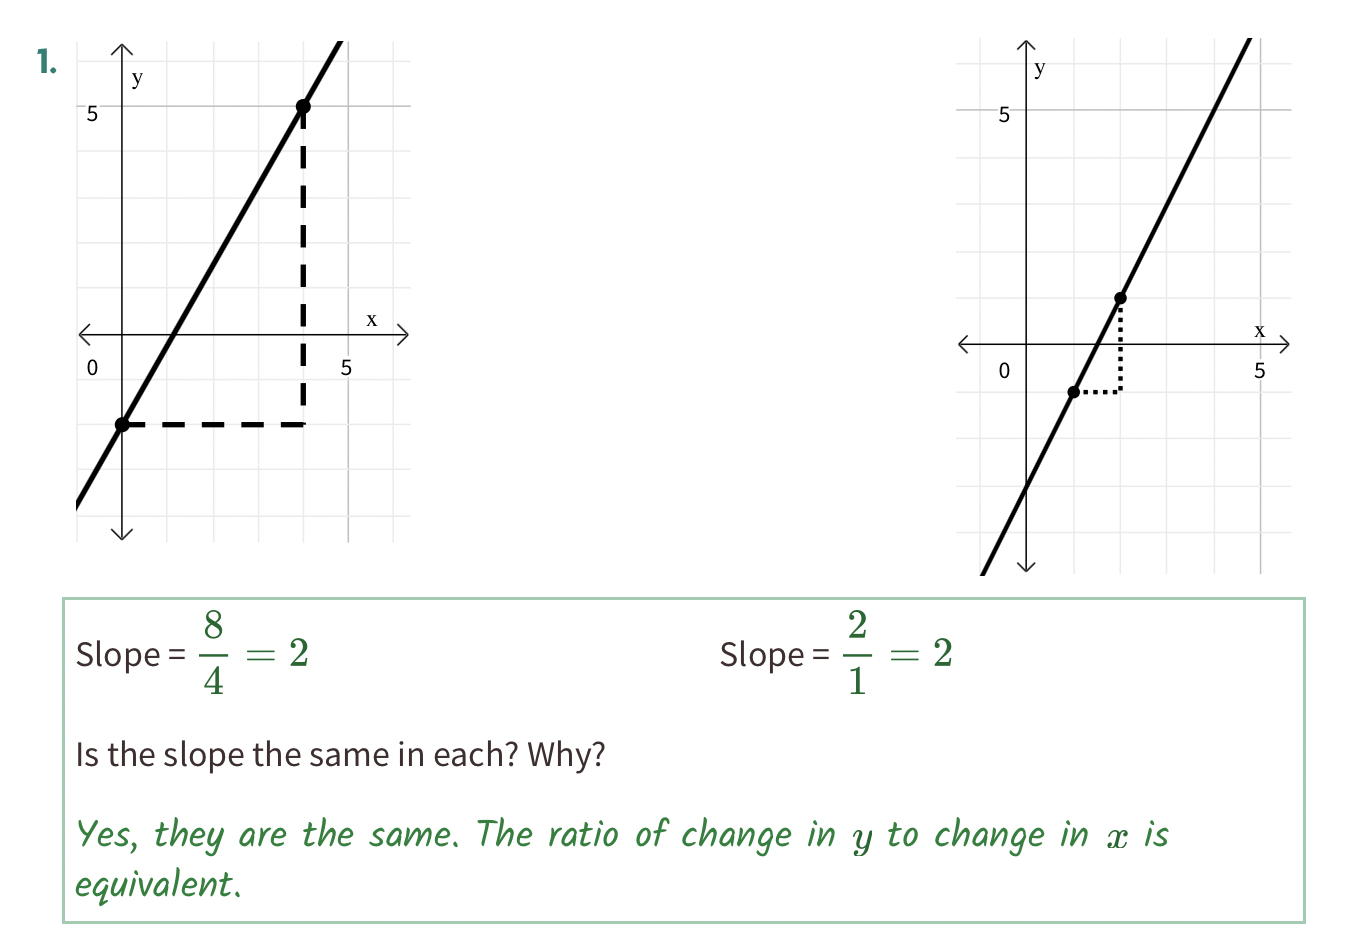

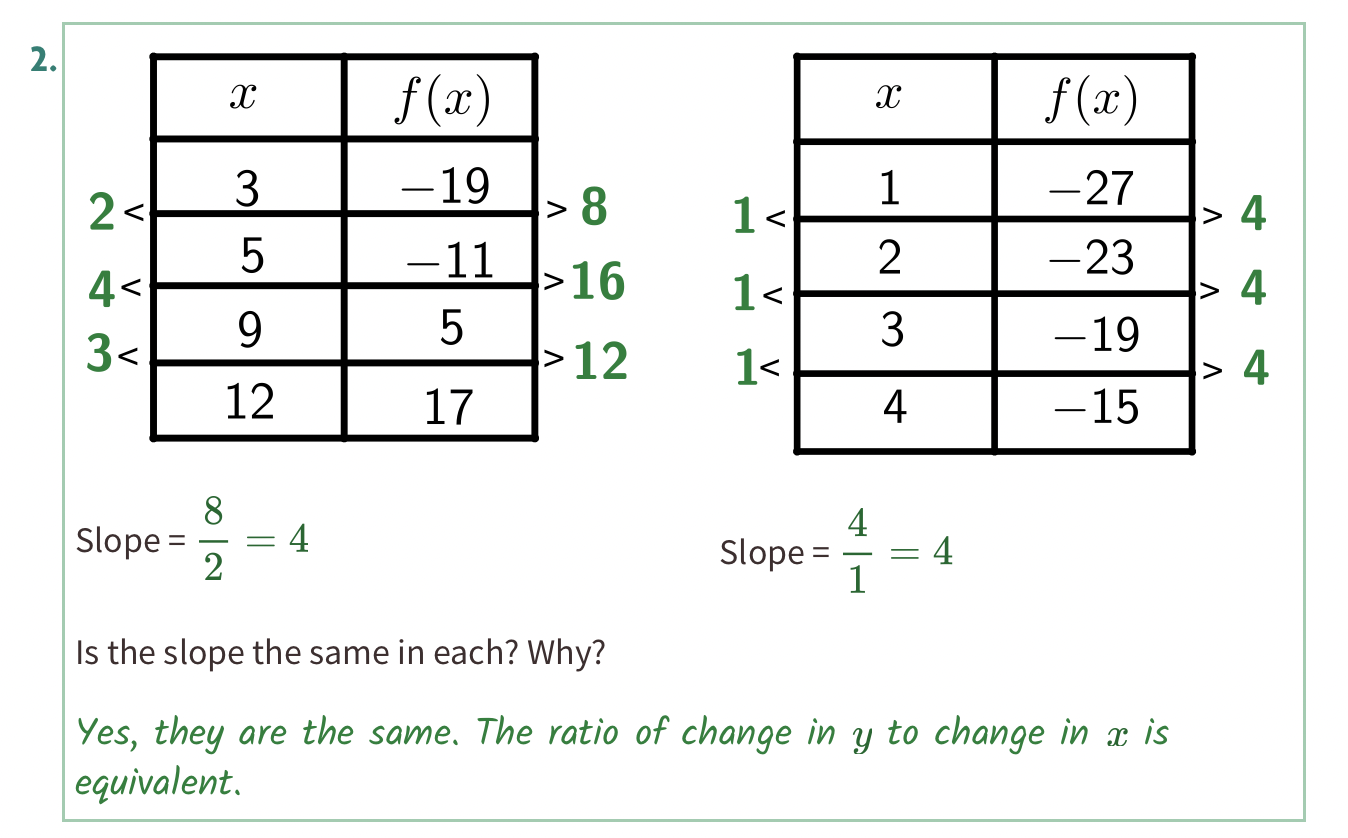

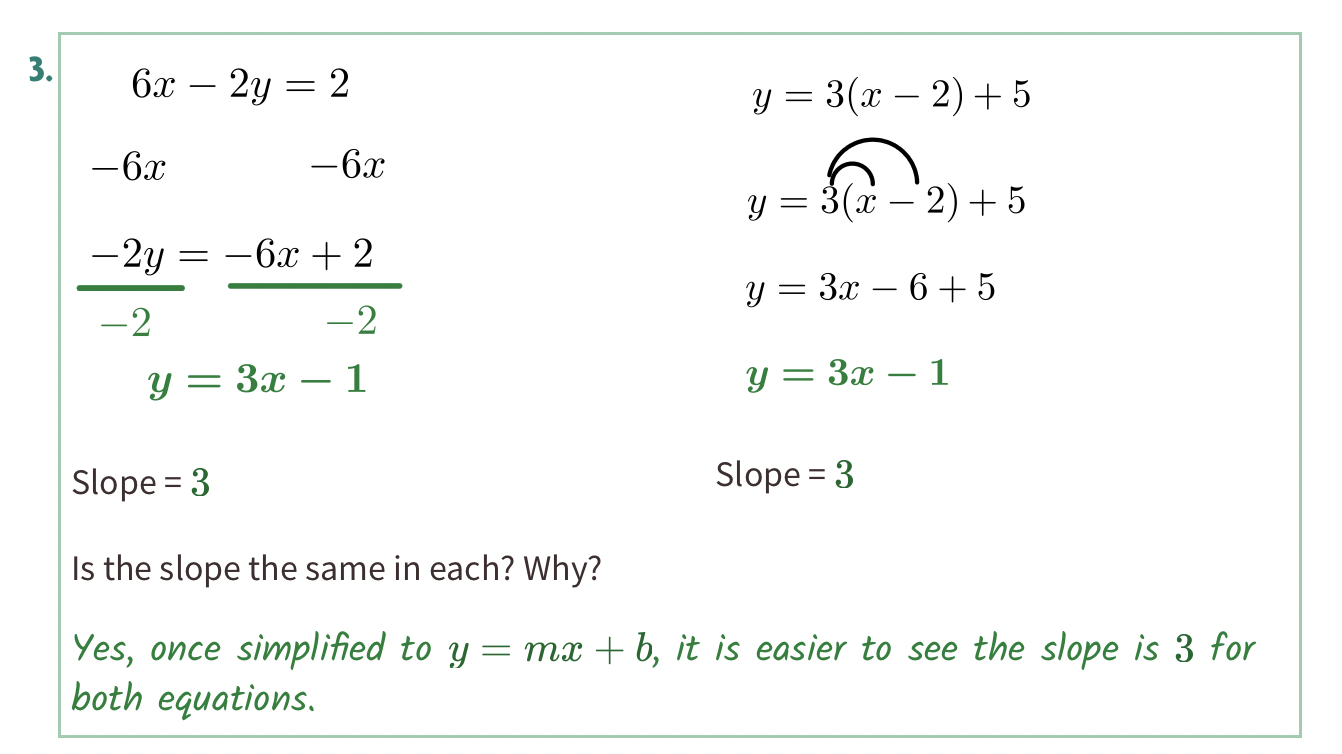

### Section 1
#### Instruction : Find the slopes and show whether or not the slopes are the same for the pairs of representations provided.

- Case 1 : Graph Vs Graph
  - $$ display linear graphs $$
    - Slope:     $\quad \quad$             Slope: 
    - Is the slope the same in each? Why?
  - answer : 
    - Slope:                  Slope: 
    - Is the slope the same in each? Why?
    - Yes, they are the same. The ratio of change in $y$ to change in $x$ is equivalent.


- Case 2 : Table vs Table
  - $$ display 2 tables $$
    - Slope:     $\quad \quad$             Slope: 
    - Is the slope the same in each? Why?
  - answer : 
    - Slope:                  Slope: 
    - Is the slope the same in each? Why?
    - Yes, they are the same. The ratio of change in $y$ to change in $x$ is equivalent.

- Case 3 : Linear EQ vs Linear EQ
  - $$ 6x-2y = 2 $$
  - $$ y=3(x-2)+5 $$
    - Slope:     $\quad \quad$             Slope: 
    - Is the slope the same in each? Why?
  - answer : 
    - Slope:                  Slope: 
    - Is the slope the same in each? Why?
    - Yes, they are the same. The ratio of change in $y$ to change in $x$ is equivalent.


In [ ]:
# #Latex setup code

# \documentclass[letterpaper,12pt]{article}%

# \usepackage{tikz}
# \usepackage{pgfplots}
# \pgfmathsetseed{\number\pdfrandomseed}
 
# \pgfplotsset{
#     mmt axis style/.style={
#         grid=both,
#         grid style={line width=.1pt, draw=gray!20},
#         major grid style={line width=.2pt,draw=gray!60},
#         axis lines=middle,
#         minor tick num=4,
#         enlargelimits={abs=0.5},
#         unit vector ratio*=1 1 1,
#         axis line style={latex-latex},
#         ticklabel style={font=\scriptsize,fill=white},
#         xlabel=$x$,
#         ylabel=$y$,
#         xlabel style={at={(ticklabel* cs:1)},anchor=west},
#         ylabel style={at={(ticklabel* cs:1)},anchor=south},
#     },
# } 


# \begin{document}

# \begin{tikzpicture}

# \begin{axis}[
#      mmt axis style,
#     xmin=-1,xmax=10,xtick={10,5,...,-1},
#     ymin=-1,ymax=15,ytick={15,10,...,-1},
# ]

# \fill[black] (axis cs: 3,2) circle(2pt);

# \end{axis}

# \end{tikzpicture}

# \end{document}

In [ ]:
def startGraph(xmin=-1,xmax=6,ymin=-6,ymax=6):
    xstart = 5*(xmin//5)
    ystart = 5*(ymin//5)
    xtick = brackify(f'{xstart},{xstart+5},...,{xmax+5}')
    ytick = brackify(f'{ystart},{ystart+5},...,{ymax+5}')

    tex = r'\begin{tikzpicture}\begin{axis}[mmt axis style,'
    tex += fr'xmin={xmin},xmax={xmax},xtick={xtick},ymin={ymin},ymax={ymax},ytick={ytick},]'
    return tex

def endGraph():
    return r'\end{axis}\end{tikzpicture}'

def drawPt(pt):
    return fr'\fill[black] (axis cs: {pt[0]},{pt[1]}) circle(2pt);'

def drawLine(expr, xmin, xmax, color='red'):
    return fr'\addplot[{color},domain={xmin}:{xmax}] {brackify(str(expr))};'

def drawSlopeTri(pt1, pt2):
    string = fr'\draw[dashed] (axis cs: {pt1[0]},{pt1[1]}) -- (axis cs: {pt1[0]},{pt2[1]});'
    string += fr'\draw[dashed] (axis cs: {pt1[0]},{pt2[1]}) -- (axis cs: {pt2[0]},{pt2[1]});'
    return string

def emptyGraph(xmin=-1,xmax=10,ymin=-1,ymax=10):
    return startGraph(xmin,xmax,ymin,ymax) + endGraph()

In [ ]:
def getSlopeTriGraph(func, pt1, pt2):
    if type(pt1)!=list:
        pt1 = [pt1] + [func.subs(pt1)]
    if type(pt2)!=list:
        pt2 = [pt2] + [func.subs(pt2)]

    graph = startGraph()
    graph += drawLine(func.expr, -1, 6)
    graph += drawSlopeTri(pt1, pt2)
    graph += drawPt(pt1) + drawPt(pt2)
    graph += endGraph()
    return graph

def MatchTheSlopes(case=1):
    if case == 1: # Graph vs. graph
        slope = Rational(getInt(-7,7),2)
        intercept = randint(-5,0) if slope>0 else randint(0,5)
        func1 = LinFunc(slope, intercept)
        intercept = randint(-5,0) if slope>0 else randint(0,5)
        func2 = LinFunc(slope, intercept)

        nums = sample(list(range(0,6)),4)
        nums.sort()
        pts1 = [[jj, func1.subs(jj)] for jj in nums[::3]]
        pts2 = [[jj, func2.subs(jj)] for jj in nums[1:3]]
        graph1 = getSlopeTriGraph(func1, pts1[0], pts1[1])
        graph2 = getSlopeTriGraph(func2, pts2[0], pts2[1])

        problem = minipagify(graph1, graph2)

        answer1 = r'$\text{Slope}=\frac'
        answer1 += brackify(pts1[1][1]-pts1[0][1]) + brackify(pts1[1][0]-pts1[0][0])
        answer1 += f'={latexify(slope)}$'
        answer2 = r'$\text{Slope}=\frac'
        answer2 += brackify(pts2[1][1]-pts2[0][1]) + brackify(pts2[1][0]-pts2[0][0])
        answer2 += f'={latexify(slope)}$'
        answer = minipagify(answer1, answer2)
    elif case == 2: # Table vs. table
        slope = getInt(-7,7)
        func1 = LinFunc(slope, randint(-9,9))
        func2 = LinFunc(slope, randint(-9,9))

        nums = sample(list(range(1,20)),4)
        nums.sort()
        problem = minipagify(func1.getTable(nums), func2.getTable([1,2,3,4]))
        
        answer1 = r'$\text{Slope}=\frac'
        answer1 += brackify(func1.subs(nums[1])-func1.subs(nums[0])) + brackify(nums[1]-nums[0])
        answer1 += f'={latexify(slope)}$'
        answer2 = r'$\text{Slope}=\frac'
        answer2 += brackify(func2.subs(2)-func2.subs(1)) + '{1}'
        answer2 += f'={latexify(slope)}$'
        answer = minipagify(answer1, answer2)
    else: # Eq vs. eq
        slope = Rational(getInt(-7,7),2)
        func1 = LinFunc(slope, randint(-7,7))
        func2 = LinFunc(slope, randint(-7,7))

        problem = signify(func1.getStdForm(mult=randint(1,3))) + r' \newline '
        problem += signify(func2.getPtSlope(getInt(-4,4), notation='y'))

        answer = r'$\text{Slope}=' + latexify(slope) + '$'

    return problem, answer

for jj in range(10):
    problem, answer = MatchTheSlopes(3)
    print(problem)
    print(answer, r'\\ \\')

NameError: ignored

## AGS 2.2.2 -  Indicate The Relationship? (SKIP?)

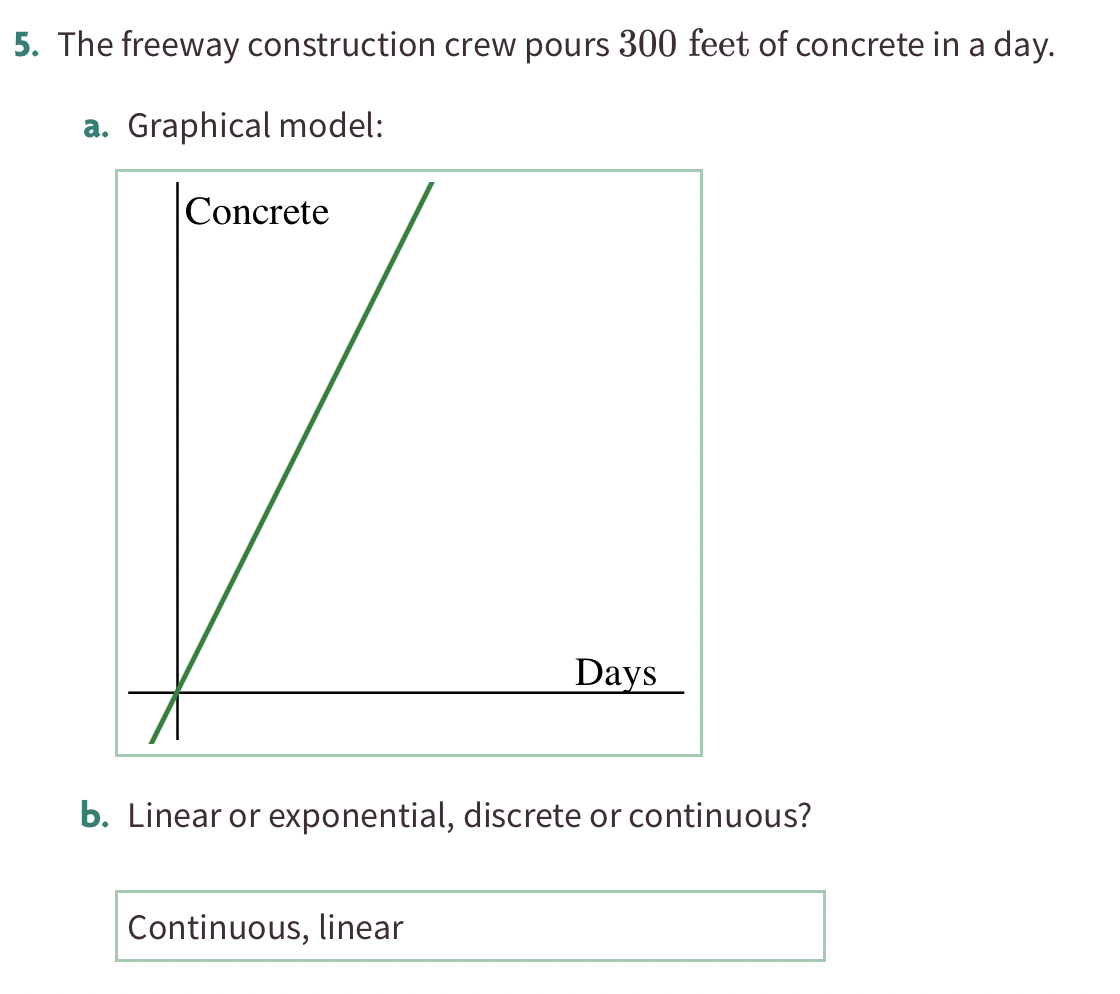

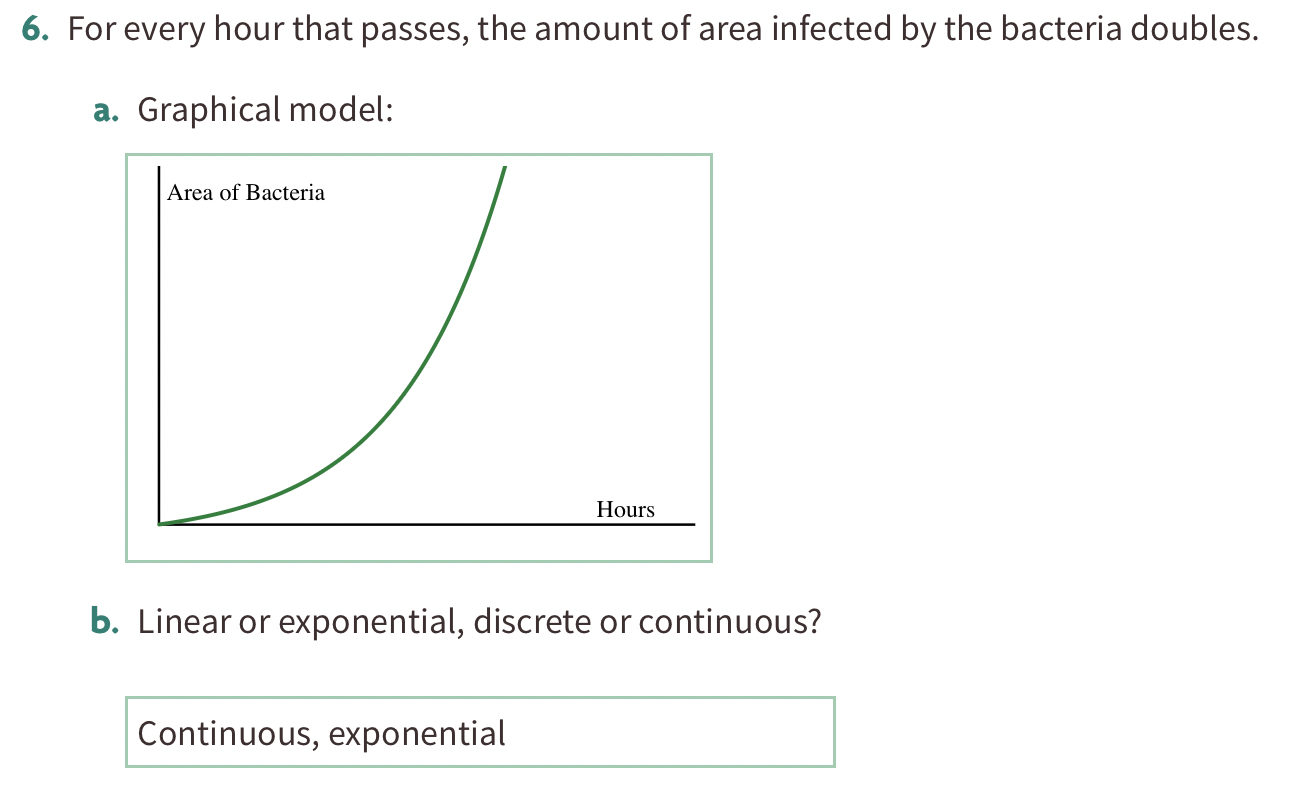

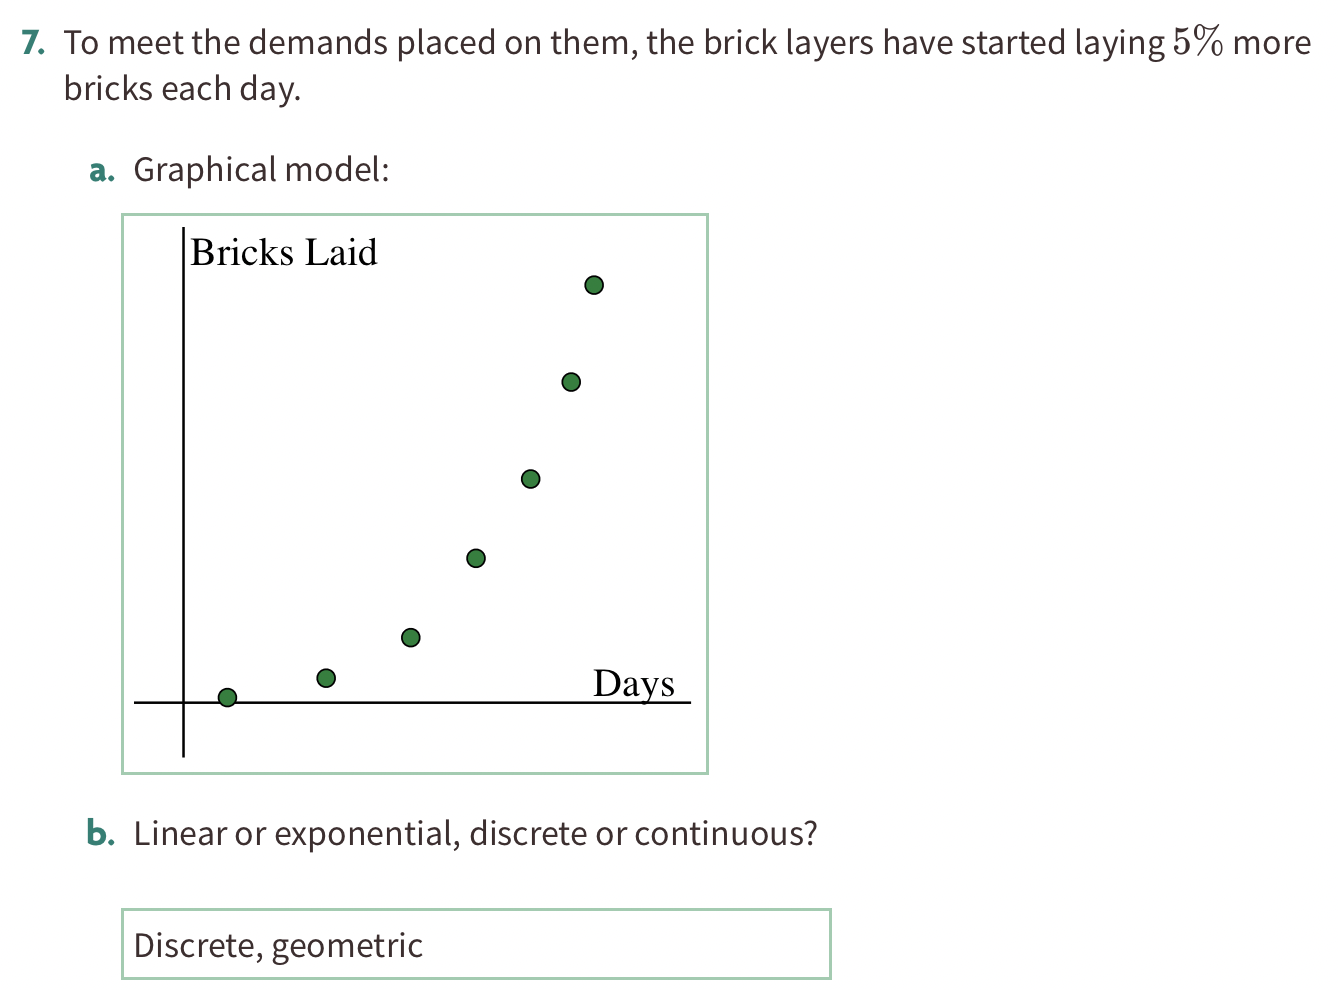

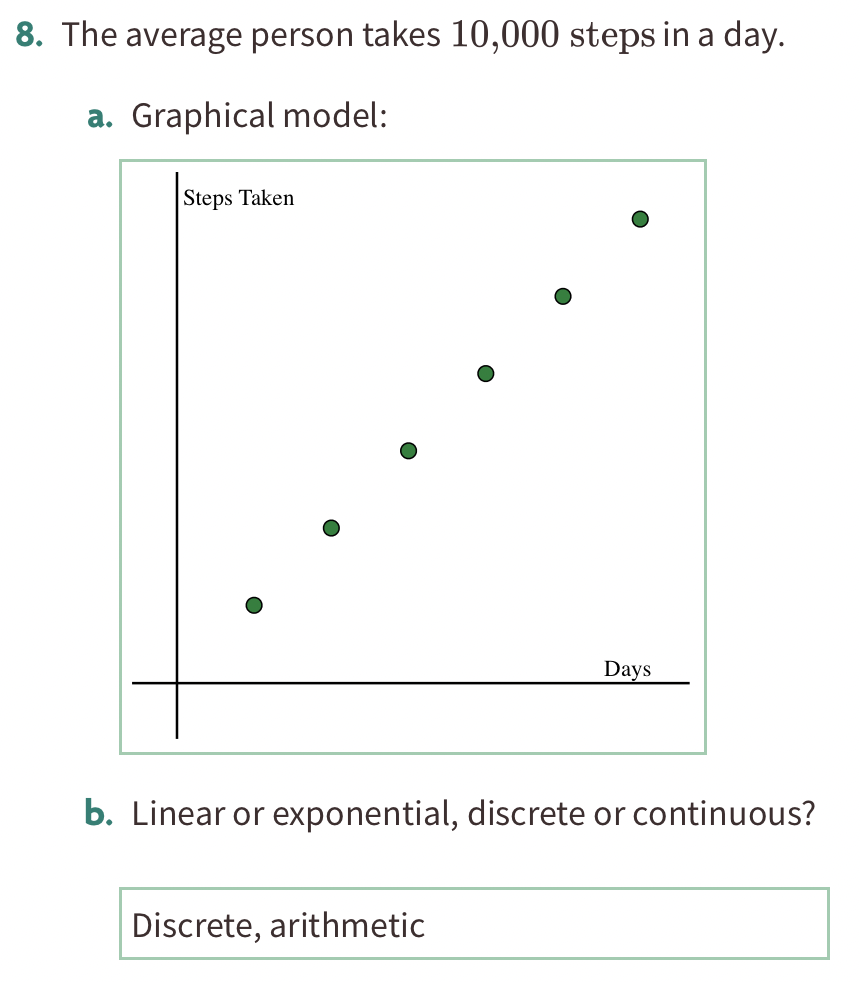

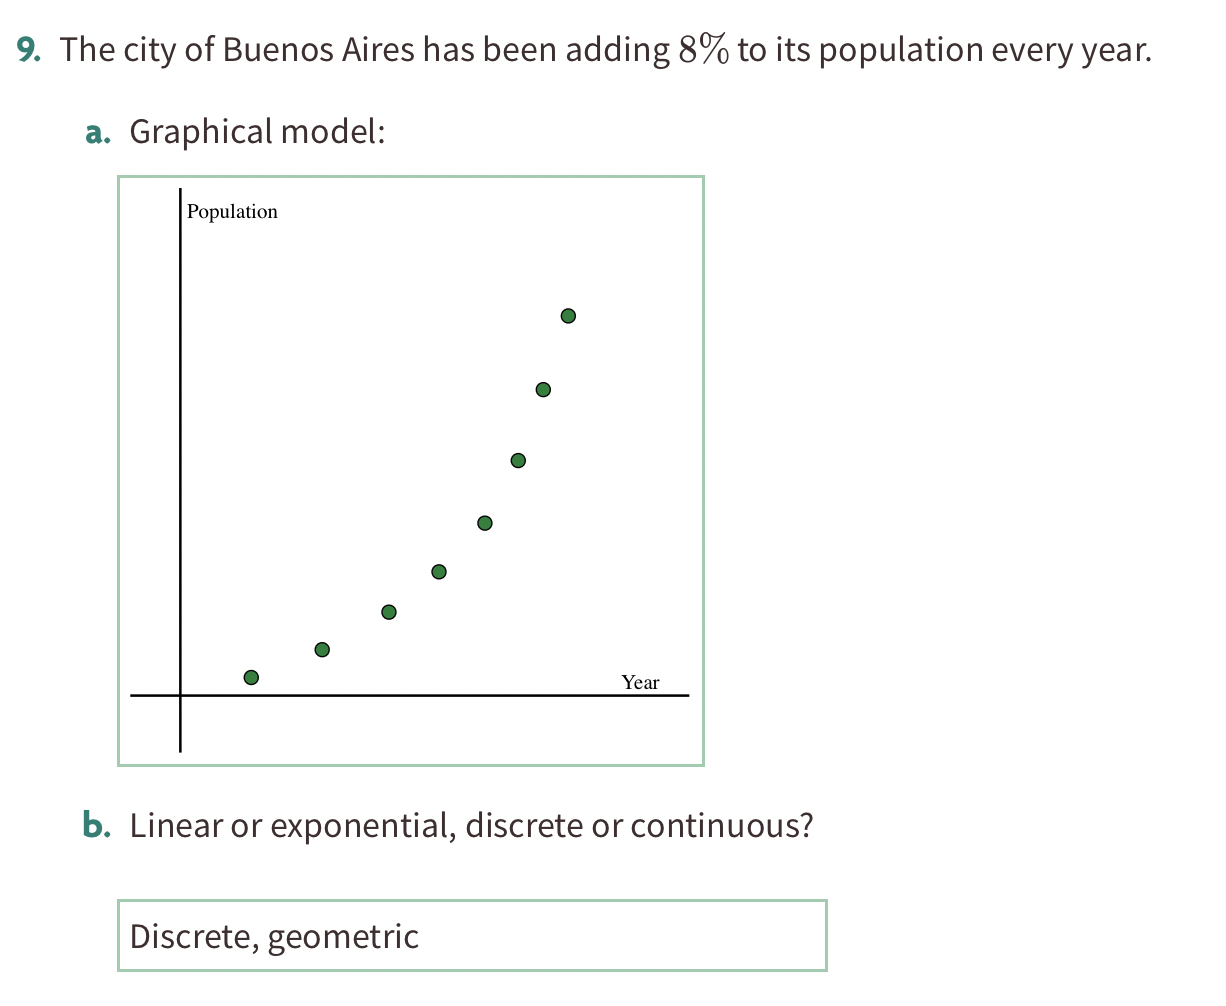

### section1 
#### instruction : Create a graphical model based on the context. Indicate if the relationship is linear or exponential and if the context is best modeled as discrete or continuous.


Combination of 2 
- Linear / Exponential
  - random# -6~6
  - generate 
- Discrete / Continuous
  - if lin generate 2 pts 
  - if geo generate 6 pts?


option - 

---
case1: Word problems
- The freeway construction crew pours $300 feet$ of concrete in a day.
- a) Graphical model:
  - $$ display empty graph here $$
  -
- b) $x$ label?
- c) $y$ label?
- d) Linear or exponential, discrete or continuous?

---
case2: For every hour that passes, the amount of area infected by the bacteria doubles.

- a) Graphical model:
  - $$ display empty graph here $$
  -
- b) $x$ label?
- c) $y$ label?
- d) Linear or exponential, discrete or continuous?

---
case3: For every hour that passes, the amount of area infected by the bacteria doubles.


- a) Graphical model:
  - $$ display empty graph here $$
  -
- b) $x$ label?
- c) $y$ label?
- d) Linear or exponential, discrete or continuous?



## AGS 2.2.3 - Solve the following equations.

### instruction : Solve for $x$. 
#### 

---

case1 :

$$1x+16 = 36$$

ans: x=20

---

case2 :

$$425x = 850$$
ans : x=2

---

case3 :

$$\frac{1}{6} x = 850$$
ans : x=2



In [ ]:
from ..ags1_master import *
from sympy import *

def notzero(min, max):
  inta = 0
  while inta == 0:
    inta = randint(min, max)
  return inta

def notequal(inta, intb, min, max):
  intb = inta
  while inta == intb:
    intb = randint(min, max)
  return intb

def case1(diff=1):
  if diff == 1:
    m = notzero(-20, 20)
    y = randint(-30, 30)
    a = notzero(-5, 5)
  if diff == 2:
    m = notzero(-40, 40)
    y = randint(-100, 100)
    a = notzero(-10, 10)
  if diff == 3:
    m = notzero(-60, 60)
    y = randint(-200, 200)
    a = notzero(-20, 20)

  if y < 0:
    equation = str(a) + "x " + str(y) + " = " + str(a*m+y)
  elif y > 0:
    equation = str(a) + "x + " + str(y) + " = " + str(a*m+y)
  else:
    equation = str(a) + "x = " + str(a*m+y)
  return equation, a

def case2(diff=1):
  if diff == 1:
    ft = notzero(1, 9)
    fb = 0
    fb = notequal(ft, fb, 1, 9)
    a = notzero(-5, 5)
  if diff == 2:
    ft = notzero(-9, 9)
    fb = 0
    fb = notequal(ft, fb, 1, 9)
    a = notzero(-10, 10)
  if diff == 3:
    ft = notzero(1, 60)
    fb = 0
    fb = notequal(ft, fb, -60, 60)
    a = notzero(-30, 30)

  equation = r'$\frac{' + str(ft) + "}{" + str(fb) + "}$x = " + str( "{:.2f}".format((ft/fb)*a) )
  return equation, a

def followingequation(diff=1, expr="latex", lvl=1):
  if lvl == 1:
    return case1(diff)
  else:
    return case2(diff)

('\\frac{27}{-56}x = 3.857142857142857', -8)

## AGS 2.2.4 - Find the recursive and explicit equations 

### section 1
#### instruction : Find the recursive and explicit equationsfor the sequences in the tables.

---

easy : 

- case 1 : arith start (1) inc (2,20)  

|Term|Value|
|-|-|
|1|20|
|2|16|
|3|12|
|4|8|

- a) Recurssive :
- b) Explicit : 

- case 2 : geo start (1) common ratio (2 - 5) or (1/2 to 1/5)

|Term|Value|
|-|-|
|1|20|
|2|16|
|3|12|
|4|8|

- a) Recurssive :
- b) Explicit : 

---
medium : 

- case 1 : arith start (4-9) inc (5,30)  

|Term|Value|
|-|-|
|4|10|
|5|20|
|6|30|
|7|40|

- a) Recurssive :
- b) Explicit : 

- case 2 : geo start (4-9) common ratio (2 - 7) or (1/2 to 1/7)

|Term|Value|
|-|-|
|11|20|
|12|25|
|13|30|
|14|35|

- a) Recurssive :
- b) Explicit : 

---
hard : 

- case 1 : arith start (10-20) inc (5,30)  

|Term|Value|
|-|-|
|11|20|
|12|25|
|13|30|
|14|35|

- a) Recurssive :
- b) Explicit : 

- case 2 : geo start (10-20) common ratio (2 - 7) or (1/3 to 1/7)

|Term|Value|
|-|-|
|11|20|
|12|60|
|13|180|
|14|540|

- a) Recurssive :
- b) Explicit : 



In [ ]:
pip install latextable


  Created wheel for latextable: filename=latextable-0.2.1-py3-none-any.whl size=6242 sha256=2a323b1bd0688386ae9b84b35be845fcfe7659dbd2a2406b33c87e6fe70d7824
  Stored in directory: /root/.cache/pip/wheels/51/dc/99/540a81a40d112def87a9a200851a58d1ed6a866cfab4e93e56
Successfully built latextable


In [ ]:
from tabulate import tabulate
from texttable import Texttable

import latextable
import sympy
import random

def table_selector(rows):
    table = Texttable()
    table.set_cols_align(["c"] * 2)
    table.set_deco(Texttable.HEADER | Texttable.VLINES)
    table.add_rows(rows)
    return(latextable.draw_latex(table))

def arith_problem_terms_gen(start, ratio, interateby):
    indexes = []
    terms = []
    terms.append(str(start))
    indexes.append(str(random.randint(-10, 10)))
    for i in range(random.randint(3,6)):
        terms.append(str(int(terms[-1]) + int(ratio)))
        indexes.append(str(int(indexes[-1]) + int(interateby)))
    return indexes, terms

def explicit_function_formatter(ratio, variable, start, notation):
    return str(sympy.latex(sympy.sympify(fr'{notation} * ({variable} - 1) + {ratio}', evaluate = False), fold_short_frac=False))  + fr", {notation}(1) = {start}"


def recursive_function_formatter(start, variable, ratio, notation):
    return sympy.latex(sympy.sympify(fr'{start} + ({variable} - 1) * {ratio}', evaluate = False), fold_short_frac=False)

def dollar_signify(input):
    return("$" + input + "$")

def explicit_function_formatter_g(ratio, variable, start, notation):
    return sympy.latex(sympy.sympify(fr'{start} * ({ratio}) ** ({variable} - 1)', evaluate = False), fold_short_frac=False)


def recursive_function_formatter_g(start, variable, ratio, notation):
    return sympy.latex(sympy.sympify(fr'{notation} *({variable}) * {ratio}', evaluate = False), fold_short_frac=False) + fr", {notation}(1) = {start}" # KEEPS DELETING THE PARATHESIS
    #f(x) = f(x-1) * R

def geo_problem_terms_gen(start, ratio, interateby):
    indexes = []
    terms = []
    terms.append(str(start))
    indexes.append(str(random.randint(-10, 10)))
    for i in range(random.randint(3,6)):
        terms.append(str(int(terms[-1]) * int(ratio)))
        indexes.append(str(int(indexes[-1]) + int(interateby)))
    return indexes, terms
    
def Arithmetic_Explicit_Recursive(option_difficulty=1, expr="latex"):
  variable = random.choice(['x', 'y', 'a', 'b', 'z', 'p', 't'])
  notation = random.choice(['L', 'K', 'U', 'R', 'D', 'W', 'G', 'H', 'V'])
  function_start = notation + "(" + variable + ")"
  problem = ""
  answer = ""

  x_layer = ""
  y_layer = ""
  term = 1
  start = random.randint(-10, 10)

  if random.randint(1,2) == 1:
    ratio = random.randint(-20, -1)
  else:
    ratio = random.randint(1, 20)
  
  if random.randint(1,2) == 1:
    x_layer, y_layer = arith_problem_terms_gen(str(start), str(ratio), term)
    answer = "Recursive Function: " + dollar_signify(function_start + " = "+ explicit_function_formatter(start, variable, ratio, notation)), "Explicit Function: " + dollar_signify(function_start + " = " + recursive_function_formatter(start, variable, ratio, notation))
  else:
    x_layer, y_layer = geo_problem_terms_gen(str(start), str(ratio), term)
    answer = "Recursive Function: " + dollar_signify(function_start + " = "+ explicit_function_formatter_g(start, variable, ratio, notation)), "Explicit Function: " + dollar_signify(function_start + " = " + recursive_function_formatter_g(start, variable, ratio, notation))
 
  rows = []
  for i in range(len(x_layer)):
    rows.append([])
    rows[i].append(dollar_signify(x_layer[i]))
    rows[i].append(dollar_signify(y_layer[i]))
  rows.insert(len(rows), [dollar_signify("..."), dollar_signify("...")])
  rows.insert(0, [dollar_signify(str(variable)), dollar_signify(str(function_start))])
  problem = table_selector(rows)

  problem = problem.replace("\\begin{table}","")
  problem = problem.replace("\\end{table}","")
  return problem, r'\\'.join(answer)

for i in range(1):
    a,b, = Arithmetic_Explicit_Recursive(1, "latex")
    print(a,b)
    


	\begin{center}
		\begin{tabular}{c|c}
			$t$ & $U(t)$ \\
			\hline
			$7$ & $0$ \\
			$8$ & $0$ \\
			$9$ & $0$ \\
			$10$ & $0$ \\
			$11$ & $0$ \\
			$...$ & $...$ \\
		\end{tabular}
	\end{center}
 Recursive Function: $U(t) = 0^{t - 1} \left(-11\right)$\\Explicit Function: $U(t) = U t \left(-11\right), U(1) = 0$
